<!-- # Overview
- Project
    - data engineer 
        - keep acceptable sessions
        - create prediction classes and eliminate end of each session
        - make same input size for rnn
        - add features if this is suitable
    - code each rnn
        - vanilla rnn
        - lstm
        - gru -->

# Overview


# Imports

In [1]:
# manipulating data
import pandas as pd
import numpy as np

# data analysis
import matplotlib.pyplot as plt 
import seaborn as sns

# Data Engineering
#### Will be done with Pandas

## Load Data

In [4]:
# global path to data (varies for user)
data_path = './shopper_data/release_10_23_2020.csv'

# load dataset
df = pd.read_csv(data_path)


In [5]:
# get column names
col_names = [c for c in df.columns]
features = col_names[:-1]

# sepearate column names into categorical and numerical
cat_cols = []
numer_cols = []

for col in col_names:
    if df[col].dtype == 'O':
        cat_cols.append(col)
    else:
        numer_cols.append(col)

## Initial Data Examination

In [6]:
df.head()

,session_id_hash,event_type,product_action,product_skus_hash,server_timestamp_epoch_ms,hashed_url
0,00000005c19449b57d8d05dfc8b5474be0654032,pageview,NaN,NaN,1544469996111,da99729886aff70a02733b6cd69ee7df35622d9302347e...
1,00006a0ada94a5186163a25e9ed9c94481c820d9,pageview,NaN,NaN,1545737959865,e2f7e0cee4272e804f0d323a3513dd01716a5a40ab9abf...
2,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908835402,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
3,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,NaN,NaN,1544908847263,ea7b2493be61ff454f8cce412f9dc281e605daec8c43b5...
4,00007d15aeb741b3cdd873cb3933351d699cc320,pageview,detail,90add4dd072e160034e98ddea257e0b59441eae00d8955...,1544909035879,8fa1ecf31ececb27ebe9c529966f3d1f907542fe138d5d...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5433611 entries, 0 to 5433610
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   session_id_hash            object
 1   event_type                 object
 2   product_action             object
 3   product_skus_hash          object
 4   server_timestamp_epoch_ms  int64 
 5   hashed_url                 object
dtypes: int64(1), object(5)
memory usage: 248.7+ MB


#### NAN values in each column

In [8]:
df.isna().sum()

session_id_hash                    0
event_type                         0
product_action               2918789
product_skus_hash            3547557
server_timestamp_epoch_ms          0
hashed_url                         0
dtype: int64

#### Value Counts (for reasonable number of classes)

In [9]:
print("Number of Unique Values for each Categoical Column:\n")
num_unique = []
for col in cat_cols:
    num_unique.append(len(df[col].unique()))
    print("{}: ".format(col), num_unique[-1])
    if num_unique[-1] < 100:
        print('\t')
        print(df[col].value_counts())
    print('\n')

Number of Unique Values for each Categoical Column:

session_id_hash:  443660


event_type:  2
	
pageview    4565253
event        868358
Name: event_type, dtype: int64


product_action:  6
	
detail      1640190
add          743363
click         69831
remove        51512
purchase       9926
Name: product_action, dtype: int64


product_skus_hash:  38345


hashed_url:  256598




In [13]:
print('Number of unique sessions: {} \n'.format(len(dfW['session_id_hash'].unique())))

Number of unique sessions: 203127 



## Handle NaN Values
- product action
- product_skus_hash

In [19]:
# No values should be NaN
dfW.isna().sum()

session_id_hash              0
event_type                   0
product_action               0
product_skus_hash            0
server_timestamp_epoch_ms    0
hashed_url                   0
dtype: int64

# Data Analysis

(array([2.510161e+06, 7.728710e+05, 3.248280e+05, 1.707060e+05,
        1.011960e+05, 6.590700e+04, 4.555000e+04, 3.236100e+04,
        2.471600e+04, 1.922100e+04, 1.511700e+04, 1.232500e+04,
        1.009200e+04, 8.543000e+03, 7.252000e+03, 6.062000e+03,
        5.159000e+03, 4.553000e+03, 4.116000e+03, 3.582000e+03,
        3.326000e+03, 2.902000e+03, 2.627000e+03, 2.475000e+03,
        2.242000e+03, 2.092000e+03, 1.978000e+03, 1.740000e+03,
        1.619000e+03, 1.514000e+03]),
 array([0.        , 0.01333333, 0.02666667, 0.04      , 0.05333333,
        0.06666667, 0.08      , 0.09333333, 0.10666667, 0.12      ,
        0.13333333, 0.14666667, 0.16      , 0.17333333, 0.18666667,
        0.2       , 0.21333333, 0.22666667, 0.24      , 0.25333333,
        0.26666667, 0.28      , 0.29333333, 0.30666667, 0.32      ,
        0.33333333, 0.34666667, 0.36      , 0.37333333, 0.38666667,
        0.4       ]),
 <BarContainer object of 30 artists>)

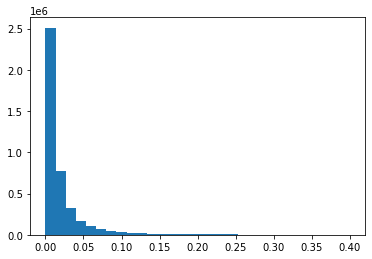

In [43]:
x = dfW.time_sitting
plt.hist(x, bins=30, range=(x.min(), 0.4))

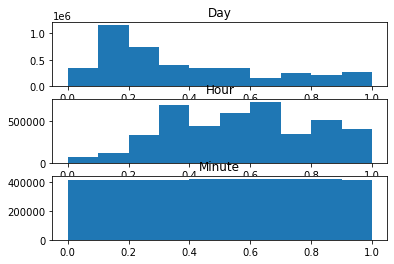

In [44]:
x1 = dfW.day
x2 = dfW.hour
x3 = dfW.minute


# Set the second subplot as active, and make the second plot. 
plt.subplot(3, 1, 1) 
plt.hist(x1) 
plt.title('Day')  

# Make the third plot 
plt.subplot(3, 1, 2) 
plt.hist(x2) 
plt.title('Hour')  

# Make the fourth plot 
plt.subplot(3, 1, 3) 
plt.hist(x3) 
plt.title('Minute') 
   
# Show the figure. 
plt.show()